####  Objective of the course 
This course is the most step-by-step spelled-out explanation of backpropagation and training of neural networks.

#### End up with this definition of a neural net 
Neural net mathematical expression for the forward pass followed by a loss function and the loss function tries to
measure the accuracy of the predictions and usually the loss will be low when your predictions are matching your
targets or where the network is basically behaving well,we  manipulate the loss function so that
when the loss is low the network is doing what you want it to do on your problem

We backward the loss use backpropagation to get the gradient and then we know how to tune all the
parameters to decrease the loss locally but then we have to iterate that process many times in what's called the gradient descent so we simply follow the gradient information and that minimizes the loss and the loss is arranged so that when the loss is minimized the network is doing what you want it to do

In [41]:
import numpy as np 
import matplotlib.pyplot as plt
import math 
from graphviz import Digraph
import torch 
import random

As introduction :
- Building intuition about derivative by following exemple.
- Go back to the [defintion](https://en.wikipedia.org/wiki/Derivative) of derivative 

In [3]:
def f(x):
    return 3*x**2 - 4-x+5

In [3]:
x = np.arange(-5,5,0.25)
y = f(x)

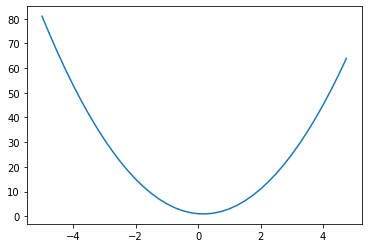

In [4]:
plt.plot(x,y)

In [7]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

3.0000029997978572

In [8]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [2]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


Comment regarding the object class value: 
- With the object Value, we have the full mathematical expression and we're building out this data structure and we know exactly how each value came to be and from what other values 
- \__repr__ : Python will internally use the wrapper function to return the string. 
- __children : keep pointers about what values produce what other values. 
- _backward : Function that do the chain rule for the backpro
- backward : Function that implement the backpro. The ordering of graphs can be achieved using something called topological sort so topological sort is basically a laying out of a graph such that all the edges go only from left to right. 



In [47]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

    

In [5]:
a = Value(2.0,label="a")
a -1 

Value(data=1.0)

- trace:  helper function that enumerates all of the nodes and edges in the graph. 
- draw_dot : draw the nodes and the edges. 

In [6]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



Build out a mathematical expression so we have multiple inputs here a b c and f going into a mathematical expression that produces a single output l and this here is visualizing the forward pass so the output of the forward pass is negative eight that's the value. 

In [7]:
draw_dot(L)

NameError: name 'L' is not defined

Now we going to run back propagation manually, we are going to
start at the end and we're going to reverse and calculate the gradient along all these intermediate values and really what we're computing for every single value here, we're going to compute the derivative of that node with respect to l. 

[Chaine rule](https://en.wikipedia.org/wiki/Chain_rule) may help. 

We can say that back propagation is is just a recursive application of chain rule backwards through the computation graph. 

In [112]:
L.grad = 1.0
f.grad = d.data
d.grad = f.data
# From the chaine rule dL/dc = dL/dd * dd/dc
c.grad = -2.0
# From the chaine rule dL/de = dL/dd * dd/de
e.grad = -2.0
# From the chaine rule dL/da = dL/de * de/da 
a.grad = -2.0*-3.0
# From the chaine rule dL/db = dL/de * de/db
b.grad = -2.0-2.0

In [114]:
# We go in the direction of the gradian to make L go up 


a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)



-7.286496


In [68]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

-3.9999999999995595


- Another example of manual backpropagation using a bit more complex example.
- We are going to back propagate through a neuron so we want to eventually build up neural networks
  and in the simplest case.
- The mathematical modelisation of a neuron can be found [here](https://www.researchgate.net/publication/336675545_Ensemble_Methods_for_Pedestrian_Detection_in_Dense_Crowds/figures?lo=1).

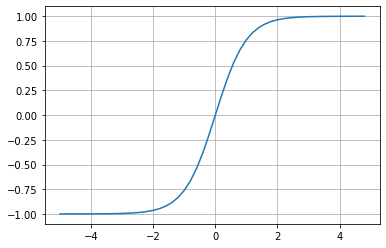

In [117]:
#Tanh function
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

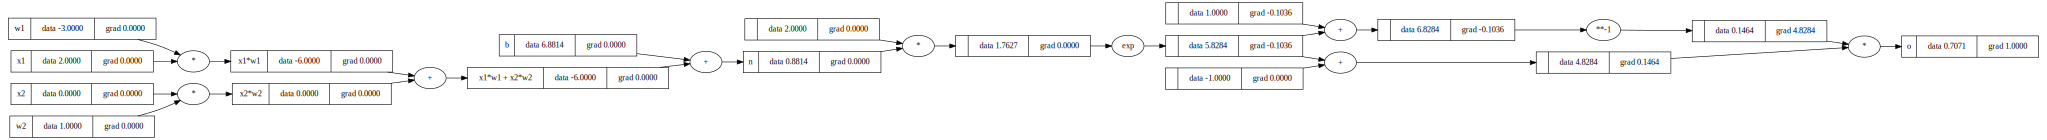

In [17]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()

o = (e-1)/(e + 1)
o.label = 'o'
o.backward()
draw_dot(o)


Same but with pytorch API 

In [37]:
x1 = torch.Tensor([2.0]).double()                
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  
b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

o.data.item()
o.backward()

print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [42]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [43]:


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)



Value(data=-0.2661625128594715)

In [44]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [48]:


for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  



0 4.782131407342492
1 3.9729052578923905
2 3.634592921263633
3 3.584859115698042
4 3.572660380236087
5 3.573087118997241
6 3.634369008423695
7 3.6408567714400553
8 3.6477705412338723
9 3.6577174155239796
10 3.664344225367181
11 3.670724104725531
12 3.6768225991552446
13 3.7077922219757466
14 3.7128560238364026
15 3.717670889421349
16 3.724857467975137
17 3.7291409860758815
18 3.735312457995788
19 3.7391536253927655
